Set parameter Username
Set parameter LicenseID to value 2597866
Academic license - for non-commercial use only - expires 2025-12-10
Set parameter Username
Set parameter LicenseID to value 2597866
Academic license - for non-commercial use only - expires 2025-12-10
Set parameter NonConvex to value 2
Set parameter LogToConsole to value 0


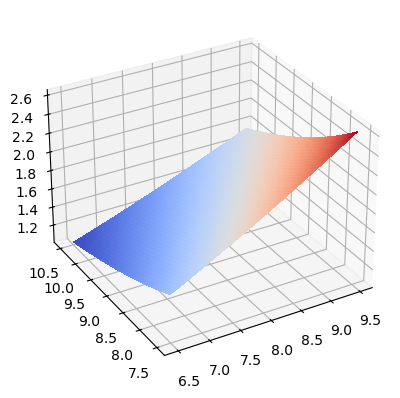


True opt p, d, val:

[ 9.5        10.18035616]
[  23722.80071848 1776277.19928152]
18308501.12921547

Total demand excess:

0.0


In [1]:
# Solve the real problem

import numpy as np
import numpy.random as npr
import pandas as pd
import gurobipy as gp
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm
import sys
sys.path.append('../src')
from gurobi_helpers import *

# Setup environment

env = gp.Env()
env.setParam('OutputFlag', 0)
env.start()

n = 2
lb = np.array([650, 750]) / 100
ub = np.array([950, 1050]) / 100
#lb = [1, 1]
#ub = [2, 2]
alpha = 10**7 * np.array([1, 1]) # I don't know how to set these
cross = 0.5
beta = np.array([[-1.9, cross], [cross, -1.2]]) # I don't know how to set these
beta = np.array([[-3.2, 0.5], [1.5, -2.2]]) # I don't know how to set these
rhs = 2.35
rhs = 1500000
rhs = 1.8e6

# Solve opt problem

env = gp.Env()

m = gp.Model('pricedemand', env = env)
m.Params.NonConvex = 2
m.Params.LogToConsole = 0

p = m.addMVar(shape = n, name = 'p', lb = lb, ub = ub)
d = m.addMVar(shape = n, name = 'd')

# mypow[i, j] will represent p[i] raised to beta[i, j]

mypow = m.addMVar(shape = (n, n), name = 'mypow')

for i in range(n):
    for j in range(n):
        m.addGenConstrPow(p[j], mypow[i, j], beta[i, j], 'FuncPieces=1000')

m.addConstr(d[0] == alpha[0] * mypow[0, 0] * mypow[0, 1])
m.addConstr(d[1] == alpha[1] * mypow[1, 0] * mypow[1, 1])

m.setObjective((p * d).sum(), gp.GRB.MAXIMIZE)
m.addConstr(p[1] >= p[0] + 0.5)
m.addConstr(p[1] <= p[0] + 1.5)
m.addConstr(d[0] + d[1] <= rhs)
#m.addConstr(d[0] >= 3 * 10**4)
m.optimize()
p_opt = p.x
d_opt = d.x

# Draw pics

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.view_init(elev = 30, azim = -120)

p0 = np.arange(start = lb[0], stop = ub[0], step = 0.01)
p1 = np.arange(start = lb[1], stop = ub[1], step = 0.01)
p0, p1 = np.meshgrid(p0, p1)
f = p0 * alpha[0] * p0 ** beta[0, 0] * p1 ** beta[0, 1] + \
    p1 * alpha[1] * p0 ** beta[1, 0] * p1 ** beta[1, 1]

surface = ax.plot_surface(p0, p1, f, cmap = cm.coolwarm, antialiased = False)

plt.show()

# fig, axs = plt.subplots(1, 2, subplot_kw = {"projection": "3d"})

#p0 = np.arange(start = lb[0], stop = ub[0] + 0.2, step = 0.2)
#p1 = np.arange(start = lb[1], stop = ub[1] + 0.2, step = 0.2)
#p0, p1 = np.meshgrid(p0, p1)
#d0 = alpha[0] * p0 ** beta[0, 0] * p1 ** beta[0, 1]
#d1 = alpha[1] * p0 ** beta[1, 0] * p1 ** beta[1, 1]

#axs[0].plot(p0.flatten(), p1.flatten(), d0.flatten(), marker = '.', linestyle = '')
#axs[0].plot(p.x[[0]], p.x[[1]], d.x[[0]], color = 'orange', marker = '.', markersize = 20)

#axs[1].plot(p0.flatten(), p1.flatten(), d1.flatten(), marker = '.', linestyle = '')
#axs[1].plot(p.x[[0]], p.x[[1]], d.x[[1]], color = 'orange', marker = '.', markersize = 20)


#surf = axs[0].plot_surface(p0, p1, d0, cmap = cm.coolwarm,
#                       linewidth = 0, antialiased = False)
#surf = axs[1].plot_surface(p0, p1, d1, cmap = cm.coolwarm,
#                       linewidth = 0, antialiased = False)

#d_pred = d_mod.predict(p_rand)

#sns.scatterplot(x = p_rand.flatten(), y = d_rand.flatten(), legend = 0, ax = axs[0])
#sns.lineplot(x = p_rand.flatten(), y = d_pred.flatten(), c = 'orange', ax = axs[0])
#axs[0].plot([p_box], [d_box], color = 'red', marker = '*', markersize = 20)
#axs[0].plot([p_chplus], [d_chplus], color = 'green', marker = '*', markersize = 20)

print('\nTrue opt p, d, val:\n')

print(p_opt)
print(d_opt)
tru_opt_val = (p_opt * d_opt).sum()
print(tru_opt_val)

print('\nTotal demand excess:\n')

print(rhs - d_opt.sum())

#m.setObjective(d.sum(), gp.GRB.MINIMIZE)
#m.optimize()
#print(d.x.sum())
#m.setObjective(d.sum(), gp.GRB.MAXIMIZE)
#m.optimize()
#print(d.x.sum())

In [3]:
######################################################################
######################################################################
######################################################################

# Solve with the learned function

import numpy as np
import numpy.random as npr
import pandas as pd

from sklearn.model_selection import train_test_split
#from sklearn.compose import make_column_transformer
#from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
#from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score
from sklearn.preprocessing import FunctionTransformer

import gurobipy as gp
import gurobipy_pandas as gppd
from gurobi_ml import add_predictor_constr

# Define sample size

ssz = 1000
npr.seed(42)

# Generate data

noize = 0.0 # Note that noise is currently zero!

fve_box    = np.array([])
fve_ch     = np.array([])
fve_chplus = np.array([])
fve_chp05  = np.array([])
fve_chp1   = np.array([])
fve_if     = np.array([])

ose_box    = np.array([])
ose_ch     = np.array([])
ose_chplus = np.array([])
ose_chp05  = np.array([])
ose_chp1   = np.array([])
ose_if     = np.array([])

ove_box    = np.array([])
ove_ch     = np.array([])
ove_chplus = np.array([])
ove_chp05  = np.array([])
ove_chp1   = np.array([])
ove_if     = np.array([])

fe_box    = np.array([])
fe_ch     = np.array([])
fe_chplus = np.array([])
fe_chp05  = np.array([])
fe_chp1   = np.array([])
fe_if     = np.array([])

env = gp.Env()

for ind in range(1000):

    p_rand = npr.uniform(lb, ub, (ssz, n))
    eps = noize * npr.normal(0, 1, (ssz, n))
    d0_rand = np.exp(eps[:, 0]) * alpha[0] * p_rand[:, 0] ** beta[0, 0] * p_rand[:, 1] ** beta[0, 1]
    d1_rand = np.exp(eps[:, 1]) * alpha[1] * p_rand[:, 0] ** beta[1, 0] * p_rand[:, 1] ** beta[1, 1]
    f_rand = p_rand[:, 0] * d0_rand + p_rand[:, 1] * d1_rand

    # Fit data

    d0_mod = make_pipeline(
        StandardScaler(), # missed this part?
        PolynomialFeatures(degree = 2),
        LinearRegression(fit_intercept = False)
    )
    d0_mod.fit(p_rand, d0_rand)

    d1_mod = make_pipeline(
        StandardScaler(),
        PolynomialFeatures(degree = 2),
        LinearRegression(fit_intercept = False)
    )
    d1_mod.fit(p_rand, d1_rand)

    # Optimize

    m = gp.Model("pricedemand", env = env)
    m.Params.NonConvex = 2
    m.Params.LogToConsole = 0

    p = m.addMVar(shape = (n), name = 'p', lb = lb, ub = ub)
    d0 = m.addVar(name = 'd0')
    d1 = m.addVar(name = 'd1')
    add_predictor_constr(m, d0_mod, p, d0)
    add_predictor_constr(m, d1_mod, p, d1)
    m.setObjective(p[0] * d0 + p[1] * d1, gp.GRB.MAXIMIZE)
    m.addConstr(p[1] >= p[0] + 0.5)
    m.addConstr(p[1] <= p[0] + 1.5)
    m.addConstr(d0 + d1 <= rhs)

    m.optimize()
    p_box = p.x
    d0_box = d0.x
    d1_box = d1.x

    u = m.addMVar(shape = (ssz), name = 'u', lb = 0, ub = 1)
    s = m.addMVar(shape = (n+2), name='s', lb=-gp.GRB.INFINITY)
    epsilon = m.addConstr(s @ s <= (0*np.sqrt(n))**2)
    m.addConstr(u.sum() == 1)

    m.addConstrs(p[i] == (u @ p_rand)[i] + s[i] for i in range(n)) 
    m.optimize()
    p_ch = p.x
    d0_ch = d0.x
    d1_ch = d1.x

    m.addConstr(d0 == u @ d0_rand + s[-2])
    m.addConstr(d1 == u @ d1_rand + s[-1])
    #m.addConstr(p[0] * d0 + p[1] * d1 == u @ f_rand)
    m.optimize()
    p_chplus = p.x
    d0_chplus = d0.x
    d1_chplus = d1.x
    
    m.remove(epsilon)
    epsilon = m.addConstr(s @ s <= (0.05*np.sqrt(n))**2)
    m.optimize()
    p_chp05 = p.x
    d0_chp05 = d0.x
    d1_chp05 = d1.x
    
    m.remove(epsilon)
    epsilon = m.addConstr(s @ s <= (0.1*np.sqrt(n))**2)
    m.optimize()
    p_chp1 = p.x
    d0_chp1 = d0.x
    d1_chp1 = d1.x
    
    #isofor
    m = gp.Model("pricedemand", env = env)
    m.Params.NonConvex = 2
    m.Params.LogToConsole = 0

    p = m.addMVar(shape = (n), name = 'p', lb = lb, ub = ub)
    d0 = m.addVar(name = 'd0')
    d1 = m.addVar(name = 'd1')
    add_predictor_constr(m, d0_mod, p, d0)
    add_predictor_constr(m, d1_mod, p, d1)
    m.setObjective(p[0] * d0 + p[1] * d1, gp.GRB.MAXIMIZE)
    m.addConstr(p[1] >= p[0] + 0.5)
    m.addConstr(p[1] <= p[0] + 1.5)
    m.addConstr(d0 + d1 <= rhs)
    
    scaler = MinMaxScaler()
    p_scaled = scaler.fit_transform(p_rand)
    p_scaled_var = m.addMVar(shape = (n), name = 'p_scaled', ub=1)
    m.addConstr(p_scaled_var == (p-scaler.data_min_)/(scaler.data_max_-scaler.data_min_))
    add_isofor_constr(m, X=p_scaled, xx=p_scaled_var, d=5)

    m.optimize()
    p_if = p.x
    d0_if = d0.x
    d1_if = d1.x

    #print('\nTrue opt p, d, val:\n')

    #print(p_opt)
    #print(d_opt)
    #tru_opt_val = (p_opt * d_opt).sum()
    #print(tru_opt_val)

    #print('\nPrice:\n')

    #print(p_box)
    #print(p_ch)
    #print(p_chplus)

    #print('\nDemand:\n')

    #print(np.array([d0_box, d1_box]))
    #print(np.array([d0_ch, d1_ch]))
    #print(np.array([d0_chplus, d1_chplus]))
    
    d_box = [d0_box, d1_box]
    d_ch = [d0_ch, d1_ch]
    d_chplus = [d0_chplus, d1_chplus]
    d_chp05 = [d0_chp05, d1_chp05]
    d_chp1 = [d0_chp1, d1_chp1]
    d_if = [d0_if, d1_if]

    # print('\nFunc val err:\n')

    val0_box    = alpha[0] * p_box[0]    ** beta[0, 0] * p_box[1]    ** beta[0, 1]
    val0_ch     = alpha[0] * p_ch[0]     ** beta[0, 0] * p_ch[1]     ** beta[0, 1]
    val0_chplus = alpha[0] * p_chplus[0] ** beta[0, 0] * p_chplus[1] ** beta[0, 1]
    val0_chp05  = alpha[0] * p_chp05[0]  ** beta[0, 0] * p_chp05[1]  ** beta[0, 1]
    val0_chp1   = alpha[0] * p_chp1[0]   ** beta[0, 0] * p_chp1[1]   ** beta[0, 1]
    val0_if     = alpha[0] * p_if[0]     ** beta[0, 0] * p_if[1]     ** beta[0, 1]

    val1_box    = alpha[1] * p_box[0]    ** beta[1, 0] * p_box[1]    ** beta[1, 1]
    val1_ch     = alpha[1] * p_ch[0]     ** beta[1, 0] * p_ch[1]     ** beta[1, 1]
    val1_chplus = alpha[1] * p_chplus[0] ** beta[1, 0] * p_chplus[1] ** beta[1, 1]
    val1_chp05  = alpha[1] * p_chp05[0]  ** beta[1, 0] * p_chp05[1]  ** beta[1, 1]
    val1_chp1   = alpha[1] * p_chp1[0]   ** beta[1, 0] * p_chp1[1]   ** beta[1, 1]
    val1_if     = alpha[1] * p_if[0]     ** beta[1, 0] * p_if[1]     ** beta[1, 1]

    vec_box    = np.array([val0_box,    val1_box   ])
    vec_ch     = np.array([val0_ch,     val1_ch    ])
    vec_chplus = np.array([val0_chplus, val1_chplus])
    vec_chp05  = np.array([val0_chp05,  val1_chp05])
    vec_chp1   = np.array([val0_chp1,   val1_chp1])
    vec_if     = np.array([val0_if,     val1_if    ])

    #print(np.linalg.norm([d0_box   , d1_box   ] - vec_box   ))
    #print(np.linalg.norm([d0_ch    , d1_ch    ] - vec_ch    ))
    #print(np.linalg.norm([d0_chplus, d1_chplus] - vec_chplus))
    
    fun_val_err_box    = np.linalg.norm(d_box    - vec_box   )
    fun_val_err_ch     = np.linalg.norm(d_ch     - vec_ch    )
    fun_val_err_chplus = np.linalg.norm(d_chplus - vec_chplus)
    fun_val_err_chp05  = np.linalg.norm(d_chp05  - vec_chp05)
    fun_val_err_chp1   = np.linalg.norm(d_chp1   - vec_chp1)
    fun_val_err_if     = np.linalg.norm(d_if     - vec_if    )

    #print(np.abs(d1_box - alpha[1] * p_box[0] ** beta[1, 0] * p_box[1] ** beta[1, 1]))
    #print(np.abs(d1_ch - alpha[1] * p_ch[0] ** beta[1, 0] * p_ch[1] ** beta[1, 1]))
    #print(np.abs(d1_chplus - alpha[1] * p_chplus[0] ** beta[1, 0] * p_chplus[1] ** beta[1, 1]))

    #print('\nOpt sol err:\n')

    opt_sol_err_box    = np.linalg.norm(p_box - p_opt)
    opt_sol_err_ch     = np.linalg.norm(p_ch - p_opt)
    opt_sol_err_chplus = np.linalg.norm(p_chplus - p_opt)
    opt_sol_err_chp05  = np.linalg.norm(p_chp05 - p_opt)
    opt_sol_err_chp1   = np.linalg.norm(p_chp1 - p_opt)
    opt_sol_err_if     = np.linalg.norm(p_if - p_opt)

    # print('\nOpt val err:\n')

    opt_val_err_box    = np.abs((p_box[0] * d0_box + p_box[1] * d1_box) - tru_opt_val)
    opt_val_err_ch     = np.abs((p_ch[0] * d0_ch + p_ch[1] * d1_ch) - tru_opt_val)
    opt_val_err_chplus = np.abs((p_chplus[0] * d0_chplus + p_chplus[1] * d1_chplus) - tru_opt_val)
    opt_val_err_chp05  = np.abs((p_chp05[0] * d0_chp05 + p_chp05[1] * d1_chp05) - tru_opt_val)
    opt_val_err_chp1   = np.abs((p_chp1[0] * d0_chp1 + p_chp1[1] * d1_chp1) - tru_opt_val)
    opt_val_err_if     = np.abs((p_if[0] * d0_if + p_if[1] * d1_if) - tru_opt_val)

    # print('\nFeas err:\n')

    # Keep in mind that feasibility is measured just wrt to the demand limit constraint

    feas_err_box    = np.maximum(0, -(rhs - val0_box - val1_box))
    feas_err_ch     = np.maximum(0, -(rhs - val0_ch - val1_ch))
    feas_err_chplus = np.maximum(0, -(rhs - val0_chplus - val1_chplus))
    feas_err_chp05  = np.maximum(0, -(rhs - val0_chp05 - val1_chp05))
    feas_err_chp1   = np.maximum(0, -(rhs - val0_chp1 - val1_chp1))
    feas_err_if     = np.maximum(0, -(rhs - val0_if - val1_if))
    
    fve_box    = np.append(fve_box   , fun_val_err_box   )
    fve_ch     = np.append(fve_ch    , fun_val_err_ch    )
    fve_chplus = np.append(fve_chplus, fun_val_err_chplus)
    fve_chp05  = np.append(fve_chp05 , fun_val_err_chp05)
    fve_chp1   = np.append(fve_chp1  , fun_val_err_chp1)
    fve_if     = np.append(fve_if    , fun_val_err_if    )

    ose_box    = np.append(ose_box   , opt_sol_err_box   )
    ose_ch     = np.append(ose_ch    , opt_sol_err_ch    )
    ose_chplus = np.append(ose_chplus, opt_sol_err_chplus)
    ose_chp05  = np.append(ose_chp05 , opt_sol_err_chp05)
    ose_chp1   = np.append(ose_chp1  , opt_sol_err_chp1)
    ose_if     = np.append(ose_if    , opt_sol_err_if    )

    ove_box    = np.append(ove_box   , opt_val_err_box   )
    ove_ch     = np.append(ove_ch    , opt_val_err_ch    )
    ove_chplus = np.append(ove_chplus, opt_val_err_chplus)
    ove_chp05  = np.append(ove_chp05 , opt_val_err_chp05)
    ove_chp1   = np.append(ove_chp1  , opt_val_err_chp1)
    ove_if     = np.append(ove_if    , opt_val_err_if    )

    fe_box    = np.append(fe_box   ,  feas_err_box   )
    fe_ch     = np.append(fe_ch    ,  feas_err_ch    )
    fe_chplus = np.append(fe_chplus,  feas_err_chplus)
    fe_chp05  = np.append(fe_chp05 ,  feas_err_chp05)
    fe_chp1   = np.append(fe_chp1  ,  feas_err_chp1)
    fe_if     = np.append(fe_if    ,  feas_err_if    )
    
    if ind % 500 == 0:
        print(str(ind/100) + '%')
    

med_fve = [np.median(fve_box), np.median(fve_ch), np.median(fve_chplus), np.median(fve_chp05), np.median(fve_chp1), np.median(fve_if)]
med_ose = [np.median(ose_box), np.median(ose_ch), np.median(ose_chplus), np.median(ose_chp05), np.median(ose_chp1), np.median(ose_if)]
med_ove = [np.median(ove_box), np.median(ove_ch), np.median(ove_chplus), np.median(ove_chp05), np.median(ove_chp1), np.median(ove_if)]
med_fe = [np.median(fe_box), np.median(fe_ch), np.median(fe_chplus), np.median(fe_chp05), np.median(fe_chp1), np.median(fe_if)]

print(med_fve / med_fve[0])
print(med_ose / med_ose[0])
print(med_ove / med_ove[0])
print(med_fe / med_fe[0])

Set parameter Username
Set parameter LicenseID to value 2597866
Academic license - for non-commercial use only - expires 2025-12-10
Set parameter NonConvex to value 2
Set parameter LogToConsole to value 0
Set parameter NonConvex to value 2
Set parameter LogToConsole to value 0
0.0%
Set parameter NonConvex to value 2
Set parameter LogToConsole to value 0
Set parameter NonConvex to value 2
Set parameter LogToConsole to value 0
Set parameter NonConvex to value 2
Set parameter LogToConsole to value 0
Set parameter NonConvex to value 2
Set parameter LogToConsole to value 0
Set parameter NonConvex to value 2
Set parameter LogToConsole to value 0
Set parameter NonConvex to value 2
Set parameter LogToConsole to value 0
Set parameter NonConvex to value 2
Set parameter LogToConsole to value 0
Set parameter NonConvex to value 2
Set parameter LogToConsole to value 0
Set parameter NonConvex to value 2
Set parameter LogToConsole to value 0
Set parameter NonConvex to value 2
Set parameter LogToConsol

In [ ]:
d_box